In [1]:
# This script performs the analysis of training a dense neural network and predicting y given X, where y and X are synthetic benchmark datasets of output and input respectevely, 
# as descirbed in Mamalakis et al. 2022. Here, we also aply many XAI mehtods to expaline the predictions of the network. 

# citation: 
# Mamalakis, A., I. Ebert-Uphoff, E.A. Barnes (2022) Neural network attribution methods for problems
# in geoscience: A novel synthetic benchmark dataset, arXiv preprint arXiv:2103.10005. 

# Editor: Dr Antonios Mamalakis (amamalak@colostate.edu)

In [2]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is AIgeo2

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package

# neural networks package
import keras
#Explaining neural networks using LRP
import innvestigate 


Using TensorFlow backend.
/Users/amamalakis/anaconda3/envs/AIgeo2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/amamalakis/anaconda3/envs/AIgeo2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/amamalakis/anaconda3/envs/AIgeo2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

In [3]:
#.............................................
# LOAD DATA
#.............................................


# load matlab data with the synthetic benchmark
# This data were generated using the matlab script GEN_SYNTHETIC_BENCHMARK
filepath = 'synth_exm_data.mat'
DATA = {}
f = h5py.File(filepath)
for k, v in f.items():
    DATA[k] = np.array(v)


sst_rn = np.array(DATA['SSTrand'])
lats = np.array(DATA['lat'])
lons= np.array(DATA['lon'])
y_synth = np.array(DATA['y'])
Cnt_tr = np.array(DATA['Cnt'])
print('data is loaded') # print message 'data is loaded'

/Users/amamalakis/anaconda3/envs/AIgeo2/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # Remove the CWD from sys.path while we load stuff.


data is loaded


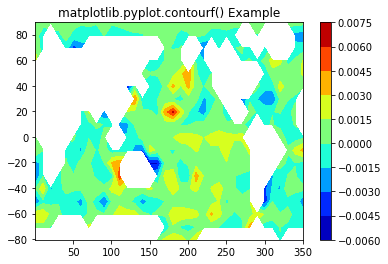

In [4]:
#.............................................
# DATA MANIPULATION AND SANITY PLOT
#.............................................

# swap axes in data arrays
Cnt_tr=np.swapaxes(Cnt_tr,-1,1)
sst_rn=np.swapaxes(sst_rn,-1,0)


# creat an array with tracking the ocean
temp=Cnt_tr[0]*0
temp[np.isnan(temp)] = 1 #tracking land
temp=temp.flatten()
temp=np.absolute(temp-1) #tracking ocean

# Vectorize the sea-surface temperature data by flattening the matrix along the spatial domains.
# We vectorize the data because we will use a fully-connected neural network

sstv_rn = sst_rn.reshape(sst_rn.shape[0]*sst_rn.shape[1], sst_rn.shape[2])

# The sst data has 'nan' values where there is land, but we can not train a network with data that has 'nan' values, so we neglect them.
sstv_rn_train= sstv_rn[temp==1]
sstv_rn_train=np.transpose(sstv_rn_train) # so we have time-->rows and grid points-->columns
lats=lats.flatten()
lons=lons.flatten()
# Flatten the synthetic output y
y_synth=y_synth.flatten()

# make a plot to double check you read correctly the data
X, Y = np.meshgrid(lons, lats) 
cs = plt.contourf(X, Y, Cnt_tr[9], cmap ="jet")   
cbar = plt.colorbar(cs)   
plt.title('matplotlib.pyplot.contourf() Example') 
plt.show()

In [4]:
#.............................................
# PREPARE THE DATA FOR TRAINING
#.............................................


# Rename the sst array to X (inputs) and Y (ouput) to stick with machine learning convention
X_all = np.copy(sstv_rn_train)
Y_all = np.copy(y_synth)

# Set the fraction of samples that will be used for testing
frac_validate = 0.1

# Separate the X and Y matrices into training and validation sub-sets
X_train = X_all[:int(-frac_validate*len(X_all))]
Y_train = Y_all[:int(-frac_validate*len(Y_all))]

X_validation = X_all[int(-frac_validate*len(X_all)):]
Y_validation = Y_all[int(-frac_validate*len(Y_all)):]

#Calculate the number of inputs into the neural network (this will be helpful later on)
# This value is the number of latitudes times the number of longitudes over the ocean
number_inputs = X_all.shape[-1]

In [5]:
#.............................................
# BUILD THE DENSE NEURAL NETWORK
#.............................................


# Define the number of hidden nodes within each layer
number_nodes_layer_one = 512
number_nodes_layer_two = 256
number_nodes_layer_three = 128
number_nodes_layer_four = 64
number_nodes_layer_five = 32
number_nodes_layer_six = 16

# Define the regularization values for each layer -- these defaults lead to a fairly accurate prediciton!
# Because I know that all grid points are contributing, I do not need regularization: NOT THE CASE IN GENERAL
l1_regularization_layer_one = 0
l2_regularization_layer_one = 0 

l1_regularization_layer_two = 0
l2_regularization_layer_two = 0

l1_regularization_layer_three = 0
l2_regularization_layer_three = 0

l1_regularization_layer_four = 0
l2_regularization_layer_four = 0

l1_regularization_layer_five = 0
l2_regularization_layer_five = 0

l1_regularization_layer_six= 0
l2_regularization_layer_six = 0

l1_regularization_layer_last = 0
l2_regularization_layer_last = 0

# Define the learning rate of the neural network
learning_rate = 0.02

# Now we will define the structure of the neural network
model = keras.models.Sequential([ \

          keras.layers.Dense(number_nodes_layer_one, input_shape=(int(number_inputs),), 
            activation='relu', use_bias=True, #kernel_initializer='he_normal', bias_initializer='he_normal', 
            kernel_initializer=keras.initializers.RandomNormal(stddev=1/number_inputs), bias_initializer=keras.initializers.Zeros(), 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_one, l2=l2_regularization_layer_one)),

          keras.layers.Dense(number_nodes_layer_two, activation='relu', use_bias=True,
            kernel_initializer='he_normal', bias_initializer='he_normal', 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_two, l2=l2_regularization_layer_two)),

          keras.layers.Dense(number_nodes_layer_three, activation='relu', use_bias=True,
            kernel_initializer='he_normal', bias_initializer='he_normal', 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_three, l2=l2_regularization_layer_three)),

          keras.layers.Dense(number_nodes_layer_four, activation='relu', use_bias=True,
            kernel_initializer='he_normal', bias_initializer='he_normal', 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_four, l2=l2_regularization_layer_four)),

          keras.layers.Dense(number_nodes_layer_five, activation='relu', use_bias=True,
            kernel_initializer='he_normal', bias_initializer='he_normal', 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_five, l2=l2_regularization_layer_five)),
                    
          keras.layers.Dense(number_nodes_layer_six, activation='relu', use_bias=True,
            kernel_initializer='he_normal', bias_initializer='he_normal', 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_six, l2=l2_regularization_layer_six)),

          keras.layers.Dense(1, use_bias=False, 
            kernel_initializer='he_normal', 
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_last, l2=l2_regularization_layer_last)),                                                   keras.layers.Activation('linear')
                            
                            ])   

#We will use the stochastic gradient descent (SGD) optimizer
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate),
              loss = 'mean_squared_error', #Our loss function is based on mean squared error
              metrics=[keras.metrics.mean_absolute_error], #We will print out the mean absolute error as the network is trained
              )

model.summary()    






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               235008    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 16        
_____

In [12]:
#.............................................
# TRAIN THE NEURAL NETWORK
#.............................................

batch_size = 32 # The number of samples the network sees before it backpropagates (batch size)
epochs =  50 # The number of times the network will loop through the entire dataset (epochs)
shuffle = True # Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 # Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

### Train the neural network!
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), 
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose) #, class_weight=class_weight)

Train on 900000 samples, validate on 100000 samples
Epoch 1/50
 - 78s - loss: 1.3827e-04 - mean_absolute_error: 0.0094 - val_loss: 1.4490e-04 - val_mean_absolute_error: 0.0096
Epoch 2/50
 - 81s - loss: 1.3287e-04 - mean_absolute_error: 0.0092 - val_loss: 1.3470e-04 - val_mean_absolute_error: 0.0092
Epoch 3/50
 - 82s - loss: 1.2814e-04 - mean_absolute_error: 0.0090 - val_loss: 1.3161e-04 - val_mean_absolute_error: 0.0091
Epoch 4/50
 - 76s - loss: 1.2424e-04 - mean_absolute_error: 0.0089 - val_loss: 1.2887e-04 - val_mean_absolute_error: 0.0090
Epoch 5/50
 - 77s - loss: 1.2069e-04 - mean_absolute_error: 0.0087 - val_loss: 1.3628e-04 - val_mean_absolute_error: 0.0093
Epoch 6/50
 - 81s - loss: 1.1765e-04 - mean_absolute_error: 0.0086 - val_loss: 1.3036e-04 - val_mean_absolute_error: 0.0091
Epoch 7/50
 - 79s - loss: 1.1475e-04 - mean_absolute_error: 0.0085 - val_loss: 1.2144e-04 - val_mean_absolute_error: 0.0088
Epoch 8/50
 - 78s - loss: 1.1207e-04 - mean_absolute_error: 0.0084 - val_loss: 1

In [14]:
#.............................................
# SAVE THE TRAINED NETWORK
#.............................................

model.save('my_model.h5')

In [6]:
#.............................................
# LOAD THE TRAINED NETWORK
#.............................................

# Recreate the exact same model, including its weights and the optimizer
model = keras.models.load_model('my_model.h5')
# Show the model architecture
model.summary()
# loss and accuracy in "new model"
loss, acc = model.evaluate(X_validation, Y_validation, verbose=2)
print('Restored model, mse: ', loss)
print('Restored model, mean absolute error: ', acc)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               235008    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 16        
_________

In [ ]:
#.............................................
# GET THE 'OCCLUSION' EXPLANATION
#.............................................

# For each testing sample we will sequentially set each pixel value ot zero 
# and determine the effect on the network prediciton.
# Under specific assumptions, the difference of the new prediciton with the prediciton when the pixel is considered 
# can give an estimate of the contribution of this pixel to the network prediciton for this sample

In [12]:
#.............................................
# 'OCCLUSION' LOOP
#.............................................

# First, we create a list to hold the output
contrib_est = []

# We will process all testing samples
for sample_ind, sample in enumerate(X_validation):

  # original prediction with all pixels considered
  sample_prediction = model.predict(sample[np.newaxis,...])
  contrib_est_sample = []
  
  # effect on the prediction when a pixel value is set to zero 
  for i in np.arange(0,len(sample)): # loop for each of the pixels 

    sample_temp=np.copy(sample)
    sample_temp[i]=0 # set to zero

    sample_prediction_temp = model.predict(sample_temp[np.newaxis,...])

    contrii = np.copy(sample_prediction-sample_prediction_temp) # effect on the prediction (difference)

    contrib_est_sample.append(contrii)

  contrib_est.append(contrib_est_sample)



In [13]:
#.............................................
# GET 'OCCLUSION' RESULTS BACK TO THE 'GLOBE' FORMAT
#.............................................


contrib_est = np.array(contrib_est) # array
contrib_est =np.swapaxes(contrib_est ,0,1)

temp1=np.swapaxes(sstv_rn,0,1) 
temp1=np.swapaxes(temp1[int(-frac_validate*len(X_all)):],0,1)*0
contrib_est_all=np.copy(temp1)

contrib_est_all[temp==1]=np.copy(contrib_est[:,:,0,0]) # adding land

contrib_est_all=contrib_est_all.reshape(sst_rn.shape[0],sst_rn.shape[1], contrib_est_all.shape[1]) # globe format

contrib_est_all =np.swapaxes(contrib_est_all ,-1,1)
contrib_est_all =np.swapaxes(contrib_est_all ,0,1)


In [10]:
#.............................................
# SAVE 'OCCLUSION' RESULTS
#.............................................

fn = 'Occlu.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('Occlu', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(contrib_est_all)

print('var size ', value.shape)
ds.close()

var size  (100000, 18, 36)


In [22]:
#.............................................
# BUILD A PURELY LINEAR MODEL AS BENCHMARK MODEL
#.............................................

model_linear = keras.models.Sequential([ \
                
                    #Define output node
          keras.layers.Dense(1, input_shape=(int(number_inputs),), 
                              use_bias=False, 
                              kernel_initializer=keras.initializers.RandomNormal(stddev=1/number_inputs),
                              #kernel_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l1_l2(l1=0,l2=0)), 
                              
          keras.layers.Activation('linear')
                            
                            ])   

#We will use the stochastic gradient descent (SGD) optimizer.
model_linear.compile(optimizer=keras.optimizers.SGD(lr=0.001),
              loss = 'mean_squared_error', # MSE
              metrics=[keras.metrics.mean_absolute_error], # MAE
              )

model_linear.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 458       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 458
Trainable params: 458
Non-trainable params: 0
_________________________________________________________________


In [24]:
#.............................................
# TRAIN THE LINEAR MODEL
#.............................................

model_linear.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), 
          batch_size=batch_size, epochs=10, shuffle=shuffle, verbose=verbose)

Train on 900000 samples, validate on 100000 samples
Epoch 1/10
 - 43s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 2/10
 - 40s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 3/10
 - 39s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 4/10
 - 39s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 5/10
 - 38s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 6/10
 - 38s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 7/10
 - 38s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 8/10
 - 38s - loss: 0.0032 - mean_absolute_error: 0.0497 - val_loss: 0.0032 - val_mean_absolute_error: 0.0495
Epoch 9/10
 - 38s - 

In [44]:
#.............................................
# GET EXPLANATIONS FROM MANY XAI METHODS
#.............................................


# Use innvestigate package
# Create the "analyzer", or the object that will generate the heatmaps given an input sample

# for the linear model
gradtinput_lin_analyzer = innvestigate.create_analyzer('input_t_gradient', model_linear) 

# for the network
DT_analyzer = innvestigate.create_analyzer('deep_taylor', model)

lrp_analyzer = innvestigate.create_analyzer('lrp.alpha_beta', model, alpha=1,beta=0)

lrp3_analyzer = innvestigate.create_analyzer('lrp.z', model)

gradtinput_analyzer = innvestigate.create_analyzer('input_t_gradient', model)

intgrad_analyzer = innvestigate.create_analyzer('integrated_gradients', model)

grad_analyzer = innvestigate.create_analyzer('gradient', model)

smoothgrad_analyzer = innvestigate.create_analyzer('smoothgrad', model)

In [45]:
#.............................................
# XAI LOOP
#.............................................

#First, create some lists to hold the output
ItGlin_heatmaps1_all = []
DT_heatmaps1_all = []
LRP_heatmaps1_all = []
LRP3_heatmaps1_all = []
ItG_heatmaps1_all = []
intG_heatmaps1_all = []
Grad_heatmaps1_all = []
SmooG_heatmaps1_all = []

prediction_all=[]
prediction_lin_all=[]

#We will process all of the testing samples
for sample_ind, sample in enumerate(X_validation):

      #Make the prediction from the model to see if the model correctly identifies the samples as El Nino
      sample_prediction_lin = model_linear.predict(sample[np.newaxis,...])
      sample_prediction = model.predict(sample[np.newaxis,...])
      
      ItGlin_heatmap1 = gradtinput_lin_analyzer.analyze(sample[np.newaxis,...])
      DT_heatmap1 = DT_analyzer.analyze(sample[np.newaxis,...]) 
      LRP_heatmap1 = lrp_analyzer.analyze(sample[np.newaxis,...]) 
      LRP3_heatmap1 = lrp3_analyzer.analyze(sample[np.newaxis,...]) 
      ItG_heatmap1 = gradtinput_analyzer.analyze(sample[np.newaxis,...]) 
      intG_heatmap1 = intgrad_analyzer.analyze(sample[np.newaxis,...]) 
      Grad_heatmap1 = grad_analyzer.analyze(sample[np.newaxis,...]) 
      SmooG_heatmap1 = smoothgrad_analyzer.analyze(sample[np.newaxis,...]) 
      

      ItGlin_heatmaps1_all.append(ItGlin_heatmap1)
      DT_heatmaps1_all.append(DT_heatmap1)
      LRP_heatmaps1_all.append(LRP_heatmap1)
      LRP3_heatmaps1_all.append(LRP3_heatmap1)
      ItG_heatmaps1_all.append(ItG_heatmap1)
      intG_heatmaps1_all.append(intG_heatmap1)
      Grad_heatmaps1_all.append(Grad_heatmap1)
      SmooG_heatmaps1_all.append(SmooG_heatmap1)

      prediction_all.append(sample_prediction)
      prediction_lin_all.append(sample_prediction_lin)
        

In [ ]:
#.............................................
# NEXT WE PERFORM DATA MANIPULATION TO GET ALL XAI RESULTS BACK TO THE 'GLOBE' FORMAT
#.............................................

In [ ]:
#Convert the list to an array 
ItGlin_heatmaps1_all = np.array(ItGlin_heatmaps1_all)
DT_heatmaps1_all = np.array(DT_heatmaps1_all)
LRP_heatmaps1_all = np.array(LRP_heatmaps1_all)
LRP3_heatmaps1_all = np.array(LRP3_heatmaps1_all)
ItG_heatmaps1_all = np.array(ItG_heatmaps1_all)
intG_heatmaps1_all = np.array(intG_heatmaps1_all)
Grad_heatmaps1_all = np.array(Grad_heatmaps1_all)
SmooG_heatmaps1_all = np.array(SmooG_heatmaps1_all)

ItGlin_heatmaps1_all =np.swapaxes(ItGlin_heatmaps1_all ,-1,1)
ItGlin_heatmaps1_all =np.swapaxes(ItGlin_heatmaps1_all ,0,1)

DT_heatmaps1_all =np.swapaxes(DT_heatmaps1_all ,-1,1)
DT_heatmaps1_all =np.swapaxes(DT_heatmaps1_all ,0,1)

LRP_heatmaps1_all =np.swapaxes(LRP_heatmaps1_all ,-1,1)
LRP_heatmaps1_all =np.swapaxes(LRP_heatmaps1_all ,0,1)

LRP3_heatmaps1_all =np.swapaxes(LRP3_heatmaps1_all ,-1,1)
LRP3_heatmaps1_all =np.swapaxes(LRP3_heatmaps1_all ,0,1)

ItG_heatmaps1_all =np.swapaxes(ItG_heatmaps1_all ,-1,1)
ItG_heatmaps1_all =np.swapaxes(ItG_heatmaps1_all ,0,1)

intG_heatmaps1_all =np.swapaxes(intG_heatmaps1_all ,-1,1)
intG_heatmaps1_all =np.swapaxes(intG_heatmaps1_all ,0,1)

Grad_heatmaps1_all =np.swapaxes(Grad_heatmaps1_all ,-1,1)
Grad_heatmaps1_all =np.swapaxes(Grad_heatmaps1_all ,0,1)

SmooG_heatmaps1_all =np.swapaxes(SmooG_heatmaps1_all ,-1,1)
SmooG_heatmaps1_all =np.swapaxes(SmooG_heatmaps1_all ,0,1)


In [ ]:
temp1=np.swapaxes(sstv_rn,0,1)
temp1=np.swapaxes(temp1[int(-frac_validate*len(X_all)):],0,1)*0

ItGlin_heatmaps1=np.copy(temp1)
DT_heatmaps1=np.copy(temp1)
LRP_heatmaps1=np.copy(temp1)
LRP3_heatmaps1=np.copy(temp1)
ItG_heatmaps1=np.copy(temp1)
intG_heatmaps1=np.copy(temp1)
Grad_heatmaps1=np.copy(temp1)
SmooG_heatmaps1=np.copy(temp1)

In [ ]:
ItGlin_heatmaps1[temp==1]=np.copy(ItGlin_heatmaps1_all[:,:,0])
DT_heatmaps1[temp==1]=np.copy(DT_heatmaps1_all[:,:,0])
LRP_heatmaps1[temp==1]=np.copy(LRP_heatmaps1_all[:,:,0])
LRP3_heatmaps1[temp==1]=np.copy(LRP3_heatmaps1_all[:,:,0])
ItG_heatmaps1[temp==1]=np.copy(ItG_heatmaps1_all[:,:,0])
intG_heatmaps1[temp==1]=np.copy(intG_heatmaps1_all[:,:,0])
Grad_heatmaps1[temp==1]=np.copy(Grad_heatmaps1_all[:,:,0])
SmooG_heatmaps1[temp==1]=np.copy(SmooG_heatmaps1_all[:,:,0])

In [ ]:
ItGlin_heatmaps1=ItGlin_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], ItGlin_heatmaps1.shape[1])

DT_heatmaps1=DT_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], DT_heatmaps1.shape[1])

LRP_heatmaps1=LRP_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], LRP_heatmaps1.shape[1])

LRP3_heatmaps1=LRP3_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], LRP3_heatmaps1.shape[1])

ItG_heatmaps1=ItG_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], ItG_heatmaps1.shape[1])

intG_heatmaps1=intG_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], intG_heatmaps1.shape[1])

Grad_heatmaps1=Grad_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], Grad_heatmaps1.shape[1])

SmooG_heatmaps1=SmooG_heatmaps1.reshape(sst_rn.shape[0],sst_rn.shape[1], SmooG_heatmaps1.shape[1])

In [ ]:
ItGlin_heatmaps1 =np.swapaxes(ItGlin_heatmaps1 ,-1,1)
ItGlin_heatmaps1 =np.swapaxes(ItGlin_heatmaps1 ,0,1)

DT_heatmaps1 =np.swapaxes(DT_heatmaps1 ,-1,1)
DT_heatmaps1 =np.swapaxes(DT_heatmaps1 ,0,1)

LRP_heatmaps1 =np.swapaxes(LRP_heatmaps1 ,-1,1)
LRP_heatmaps1 =np.swapaxes(LRP_heatmaps1 ,0,1)

LRP3_heatmaps1 =np.swapaxes(LRP3_heatmaps1 ,-1,1)
LRP3_heatmaps1 =np.swapaxes(LRP3_heatmaps1 ,0,1)

ItG_heatmaps1 =np.swapaxes(ItG_heatmaps1 ,-1,1)
ItG_heatmaps1 =np.swapaxes(ItG_heatmaps1 ,0,1)

intG_heatmaps1 =np.swapaxes(intG_heatmaps1 ,-1,1)
intG_heatmaps1 =np.swapaxes(intG_heatmaps1 ,0,1)

Grad_heatmaps1 =np.swapaxes(Grad_heatmaps1 ,-1,1)
Grad_heatmaps1 =np.swapaxes(Grad_heatmaps1 ,0,1)

SmooG_heatmaps1 =np.swapaxes(SmooG_heatmaps1 ,-1,1)
SmooG_heatmaps1 =np.swapaxes(SmooG_heatmaps1 ,0,1)


In [ ]:
#.............................................
# NEXT WE SAVE ALL XAI RESULTS
#.............................................

In [ ]:

fn = 'ItGlin.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('ItGlin', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(ItGlin_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'DT.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('DT', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(DT_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'LRP.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('LRP', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(LRP_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'LRPz.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('LRPz', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(LRP3_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'ItG.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('ItG', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(ItG_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'intG.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('intG', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(intG_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'Grad.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('Grad', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(Grad_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'SmooG.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
lat = ds.createDimension('lat', 18)
lon = ds.createDimension('lon', 36)

times = ds.createVariable('time', 'f4', ('time',))
latss = ds.createVariable('lat', 'f4', ('lat',))
lonss = ds.createVariable('lon', 'f4', ('lon',))
value = ds.createVariable('SmooG', 'f4', ('time', 'lat', 'lon',))
value.units = 'unitless'

latss[:] = np.copy(lats)
lonss[:] = np.copy(lons)
value[:] = np.copy(SmooG_heatmaps1)

print('var size ', value.shape)
ds.close()

In [ ]:
fn = 'predictions.nc'
ds = nc.Dataset(fn, 'w', format='NETCDF4')

time = ds.createDimension('time', 100000)
times = ds.createVariable('time', 'f4', ('time',))

value1 = ds.createVariable('y_hat_lin', 'f4', ('time',))
value1.units = 'unitless'
value2 = ds.createVariable('y_hat_NN', 'f4', ('time',))
value2.units = 'unitless'

value1[:] = np.array(prediction_lin_all)
value2[:] = np.array(prediction_all)

print('var size ', value1.shape)
ds.close()